## Import des packages

In [ ]:
#!pip install numpy pathlib pandas keras tensorflow scikit-learn pyarrow requests tqdm plotly matplotlib TKAN

  Using cached numpy-2.3.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pathlib-1.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached pandas-2.3.0-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached scikit_learn-1.7.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached pyarrow-20.0.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.1.0-py3-none-any.whl

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importation des modules nécessaires
import keras
from sklearn.preprocessing import MinMaxScaler

# Gestionnaire de données
from data.DataManager import DataManager

# Modèles de Deep Learning
from dl_models.MLPs import create_mlp_model,  LRHistory
from dl_models.CNNs import create_cnn_model
from dl_models.RNNs import GRU, TKAN, create_rnn_model

# Métriques de performance / comparaison de modèles
from utils.visualization_tools import evaluate_and_plot
from utils.papers_runners import PaperEstimatorsRunner

In [2]:
keras.utils.set_random_seed(72)

# Nombre d'itération / taille de batch
N_MAX_EPOCH = 100
BATCH_SIZE = 32

# Liste de callbacks à utiliser dans les modèles
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.00001,
        patience = 10,
        mode = "min",
        restore_best_weights=True
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.25,
        patience = 5,
        min_delta = 0.00001,
        verbose = 0
    ),

    LRHistory()
]

# Import des données

In [ ]:
# Définition des périodes de récupération
train_period: list = [(2023,7), (2023,8), (2023, 9), (2023,10)]
test_period: list = [(2023,11)]

# Choix lié à l'utilisation des indicateurs de dépendance sérielle
use_serial_dependance: bool = False

# Définition des actifs à récupérer
cryptos_train: list = ["ETHUSDT", "BNBUSDT", "XRPUSDT", "SOLUSDT", "ADAUSDT", "DOTUSDT"]
cryptos_test: list = ["MATICUSDT", "TRXUSDT"]

# Récupération du nombre d'actifs
nb_asset_train: int = len(cryptos_train)
nb_asset_test: int = len(cryptos_test)

# Création du datamanager pour gérer les données d'entrainement + import
manager_train: DataManager = DataManager(symbols=cryptos_train, dates=train_period, light=True)
manager_train.download_and_prepare_data()

# Construction des features / labels pour les données d'entrainement
feature_paths = manager_train.load_features(use_serial_dependance,use_tick_size=True)
labels_paths = manager_train.build_labels()

# Création du datamanager pour gérer les données de test (et import)
manager_test: DataManager = DataManager(symbols=cryptos_test, dates=test_period, light=True)
manager_test.download_and_prepare_data()

# Construction des features et labels pour les données de test
feature_paths_test = manager_test.load_features(use_serial_dependance,use_tick_size=True)
labels_paths_test = manager_test.build_labels()


# Test dataframe de construction de test et val
X_train, X_val, y_train, y_val = manager_train.build_train_val_dataset()

# Construction des tests
X_test, y_test = manager_test.build_train_val_dataset(is_test=True)

# Standardisation des features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test).reshape(X_test.shape)

# Standardisation des labels (pour pas avoir des valeurs trop proches de 0)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Récupération des estimateurs papiers sur l'ensemble de test
runner = PaperEstimatorsRunner(
    symbols = cryptos_test,          
    periods = [(2023, 11)] * len(cryptos_test), 
    light_download = True)

df_est  = runner.get_estimates()
df_lab  = runner._load_labels_all()
df_all  = df_est.join(df_lab["spread_real"])
y_true  = df_all["spread_real"].values
paper_daily = df_all.drop(columns="spread_real")

# Métriques (toutes)
df_perf = runner.evaluate()


Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-07.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-07.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-08.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-08.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-09.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-09.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw da

## CNN

TRAIN CNN : (576, 1440, 16) (576, 1)
TRAIN CNN : (144, 1440, 16) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 114.7286 - val_loss: 0.2325 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3533 - val_loss: 0.2149 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2209 - val_loss: 0.2138 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2173 - val_loss: 0.2126 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2160 - val_loss: 0.2112 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2146 - val_loss: 0.2098 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2131 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2114 - val_loss: 0.2065 - learning_rate: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23

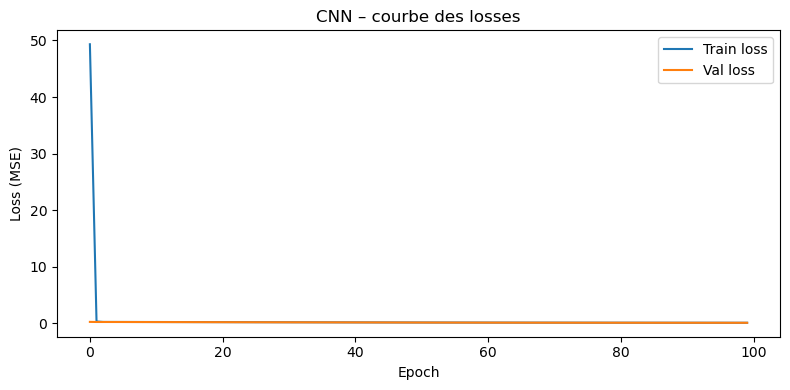

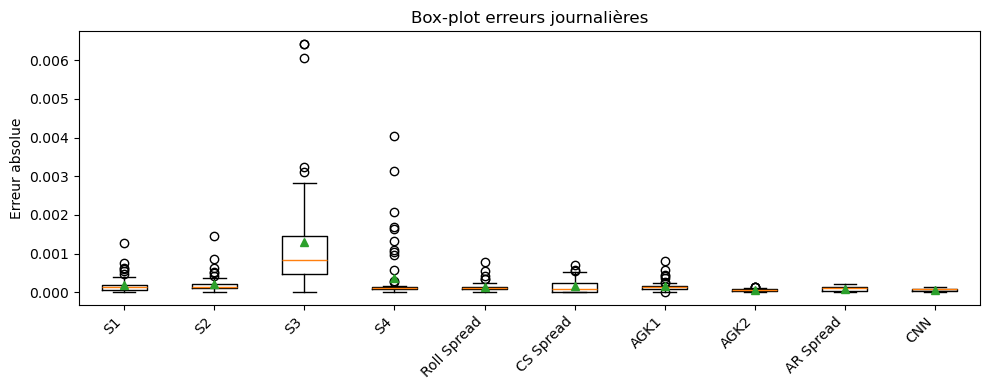

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
CNN,NaN,0.000012,0.000009


,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
CNN,NaN,0.000012,0.000009


In [4]:
# Train CNN
X_tr_cnn, y_tr_cnn = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='cnn',nb_assets=nb_asset_train,minutes_per_day=1440)
print("TRAIN CNN :", X_tr_cnn.shape, y_tr_cnn.shape)

#  Val CNN
X_val_cnn, y_val_cnn = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='cnn',nb_assets=nb_asset_train,minutes_per_day=1440)
print("TRAIN CNN :", X_val_cnn.shape, y_val_cnn.shape)

# Création et entraînement du CNN
input_shape = X_tr_cnn.shape[1:]     # (1440, 16)
cnn = create_cnn_model(input_shape=input_shape, model_type="simple",output_activation='linear')

history = cnn.fit(X_tr_cnn, y_tr_cnn,validation_data=(X_val_cnn, y_val_cnn),epochs=N_MAX_EPOCH,batch_size=BATCH_SIZE,verbose=1,callbacks=callbacks)

# Formatage des features de test
X_te_cnn, y_te_cnn = manager_test.format_data(X_test_scaled,y_test_scaled,model_type='cnn',nb_assets=nb_asset_test,minutes_per_day=1440)
print("TEST CNN :", X_te_cnn.shape, y_te_cnn.shape)

# Résultat pour le CNN
evaluate_and_plot(model = cnn,X = X_te_cnn,y = y_te_cnn,manager = manager_test,scaler_y=scaler_y,title = "CNN",
                  history = history,paper_daily = paper_daily,paper_metrics = df_perf,y_true_daily = y_true)  



## MLP

TRAIN MLP : (576, 23040) (576, 1)
VAL MLP : (144, 23040) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4315 - val_loss: 0.1944 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1136 - val_loss: 0.0752 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0809 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0578 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0549 - val_loss: 0.1271 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0792 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0672 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0409 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - 

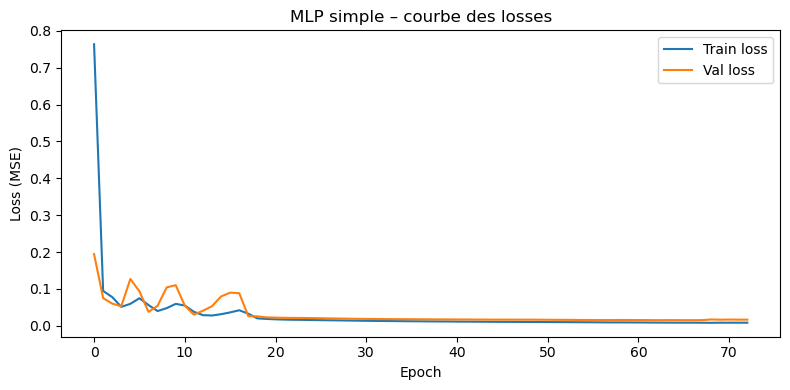

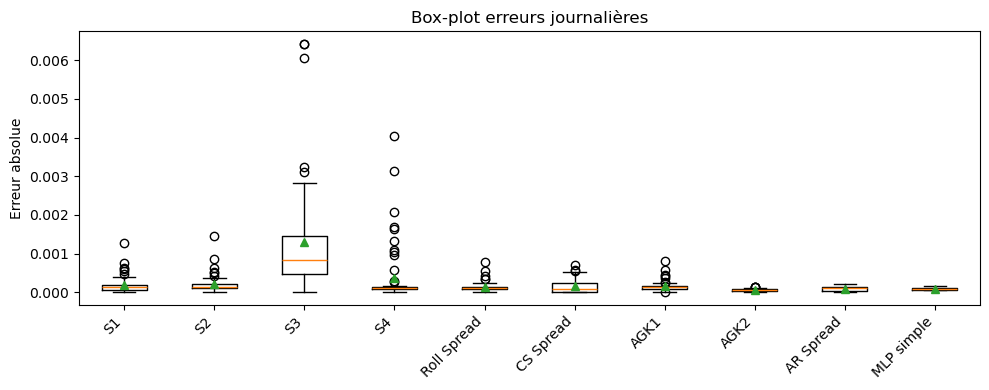

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
MLP simple,NaN,0.000101,0.000080


,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
MLP simple,NaN,0.000101,0.000080


In [5]:
# Mise en forme des données pour le MLP
X_tr_mlp, y_tr_mlp = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='mlp',nb_assets=nb_asset_train,minutes_per_day=1440)    
print("TRAIN MLP :", X_tr_mlp.shape, y_tr_mlp.shape)

#  Val CNN
X_val_mlp, y_val_mlp = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='mlp',nb_assets=nb_asset_train,minutes_per_day=1440)
print("VAL MLP :", X_val_mlp.shape, y_val_mlp.shape)


# Construction et entraînement du modèle MLP
input_shape = X_tr_mlp.shape
mlp = create_mlp_model(input_shape=input_shape,model_type="simple",hidden_dims=[128, 64, 32],output_activation  = "linear")
    

history_mlp = mlp.fit(X_tr_mlp, y_tr_mlp,validation_data = (X_val_mlp, y_val_mlp),epochs=N_MAX_EPOCH,batch_size=BATCH_SIZE,verbose=1,callbacks=callbacks)

#Préparation du set de test au même format
X_te_mlp, y_te_mlp = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='mlp',nb_assets=nb_asset_test,minutes_per_day=1440)
print("TEST  MLP :", X_te_mlp.shape, y_te_mlp.shape)

# Graphique et comparaison avec les estimateurs de Garcin
evaluate_and_plot(model = mlp,X = X_te_mlp,y = y_te_mlp,manager = manager_test,title = "MLP simple",
                  scaler_y= scaler_y,history = history_mlp,paper_daily = paper_daily,paper_metrics = df_perf,y_true_daily = y_true,)      

# LSTM (à partir de l'API Keras)

TRAIN RNN : (576, 1440, 16) (576, 1)
VAL   RNN : (144, 1440, 16) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - loss: 0.1490 - mae: 0.3240 - val_loss: 0.0677 - val_mae: 0.2130 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - loss: 0.0635 - mae: 0.2005 - val_loss: 0.0501 - val_mae: 0.1555 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - loss: 0.0533 - mae: 0.1675 - val_loss: 0.0510 - val_mae: 0.1558 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - loss: 0.1032 - mae: 0.2247 - val_loss: 0.0607 - val_mae: 0.1770 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - loss: 0.0593 - mae: 0.1815 - val_loss: 0.0532 - val_mae: 0.1761 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 356ms/step - loss: 0.0546 - mae: 0.1658 - val_loss: 0.1642 - val_mae: 0.2834 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - loss: 0.1016 

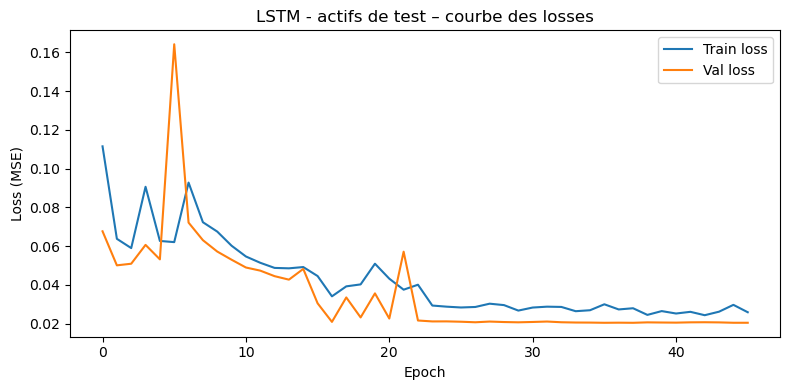

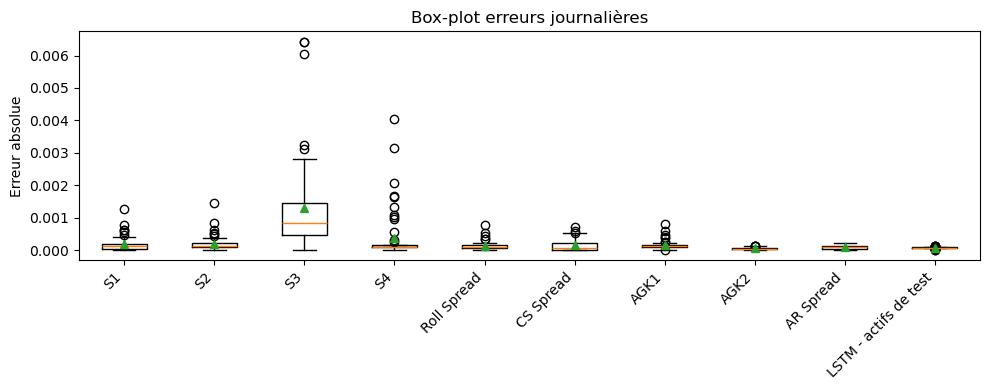

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
LSTM - actifs de test,NaN,0.000075,0.000060


In [6]:
# Mise en forme TRAIN / VAL  
X_tr_rnn, y_tr_rnn = manager_train.format_data(X_train_scaled, y_train_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("TRAIN RNN :", X_tr_rnn.shape, y_tr_rnn.shape)

X_val_rnn, y_val_rnn = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("VAL   RNN :", X_val_rnn.shape, y_val_rnn.shape)

from dl_models.RNNs import create_native_lstm_model

input_shape = X_tr_rnn.shape[1:] 
rnn = create_native_lstm_model(input_shape, nb_assets=1)


# Entraînement
history_rnn = rnn.fit(X_tr_rnn, y_tr_rnn,validation_data = (X_val_rnn, y_val_rnn),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)
    
# Préparation du TEST
X_te_rnn, y_te_rnn = manager_test.format_data(X_test_scaled, y_test_scaled,model_type = 'rnn',nb_assets = nb_asset_test,minutes_per_day = 1440)
    
# Évaluation & visualisation
df_compare_rnn = evaluate_and_plot(model = rnn,X = X_te_rnn,y = y_te_rnn,manager = manager_test,scaler_y = scaler_y,title = "LSTM - actifs de test",
                                   history = history_rnn,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily  = y_true)

## RNN GRU

TRAIN GRU : (576, 1440, 16) (576, 1)
VAL GRU : (144, 1440, 16) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 706s 18s/step - loss: 0.2530 - mae: 0.3653 - val_loss: 0.1277 - val_mae: 0.3018 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 183s 10s/step - loss: 0.1272 - mae: 0.3060 - val_loss: 0.1041 - val_mae: 0.2758 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 192s 10s/step - loss: 0.1193 - mae: 0.2970 - val_loss: 0.0986 - val_mae: 0.2688 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 238s 13s/step - loss: 0.1142 - mae: 0.2855 - val_loss: 0.1703 - val_mae: 0.2965 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - loss: 0.1295 - mae: 0.2864 - val_loss: 0.1074 - val_mae: 0.2666 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 159s 9s/step - loss: 0.1089 - mae: 0.2739 - val_loss: 0.0845 - val_mae: 0.2499 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 159s 9s/step - loss: 0.0911 - ma

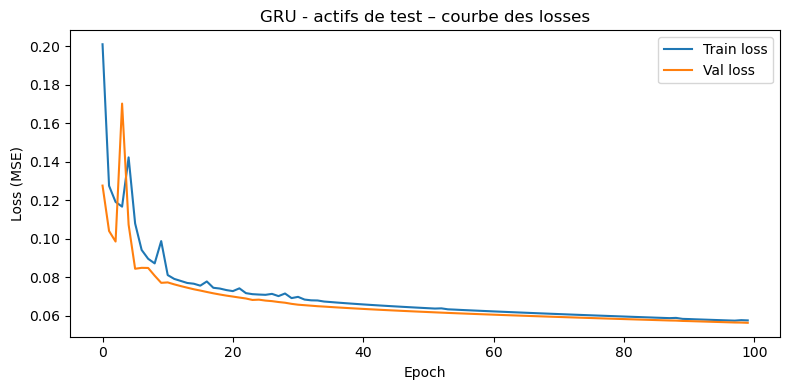

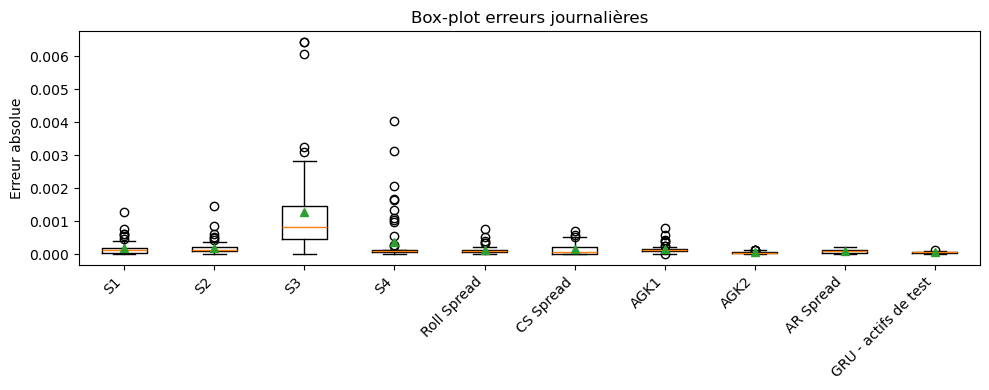

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
GRU - actifs de test,NaN,0.000055,0.000044


In [8]:
X_tr_gru, y_tr_gru = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='rnn',nb_assets=nb_asset_train,minutes_per_day=1440) 
print("TRAIN GRU :", X_tr_gru.shape, y_tr_gru.shape)

X_val_gru, y_val_gru = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("VAL GRU :", X_val_gru.shape, y_val_gru.shape)


input_shape = X_tr_gru.shape[1:]  
gru_model = create_rnn_model(input_shape = input_shape,nb_assets = 1,rnn_layer = GRU(units=100, return_sequences=False, dropout=0.3),use_conv = False)
    
history_gru = gru_model.fit(X_tr_gru, y_tr_gru,validation_data = (X_val_gru, y_val_gru),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)  
    
X_te_gru, y_te_gru = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='rnn',nb_assets=1,minutes_per_day=1440)
print("TEST GRU :", X_te_gru.shape, y_te_gru.shape)

df_compare_gru = evaluate_and_plot(model = gru_model,X = X_te_gru,y = y_te_gru,manager = manager_test,scaler_y = scaler_y,
                                   title = "GRU - actifs de test",history = history_gru,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily = y_true)    
    

## RNN TKAN

TRAIN TKAN : (571, 5, 23040) (571, 1)
VAL   TKAN : (139, 5, 23040) (139, 1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.4313 - mae: 0.4894 - val_loss: 0.1986 - val_mae: 0.3299 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2337 - mae: 0.3622 - val_loss: 0.1986 - val_mae: 0.3299 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2337 - mae: 0.3622 - val_loss: 0.1986 - val_mae: 0.3298 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2336 - mae: 0.3621 - val_loss: 0.1985 - val_mae: 0.3297 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2333 - mae: 0.3615 - val_loss: 0.1967 - val_mae: 0.3255 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2073 - mae: 0.3376 - val_loss: 0.0871 - val_mae: 0.2442 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1062 - ma

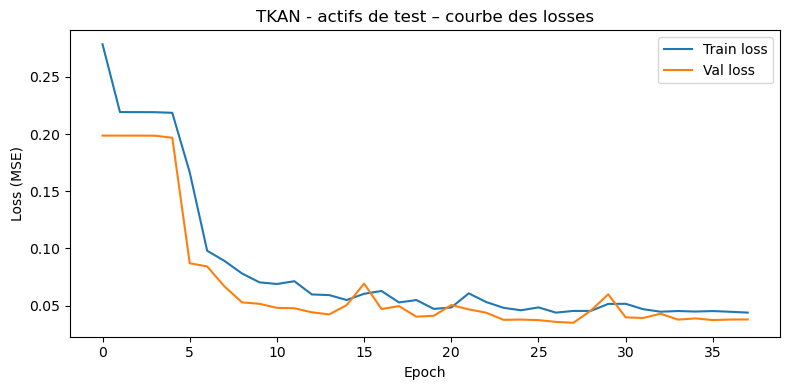

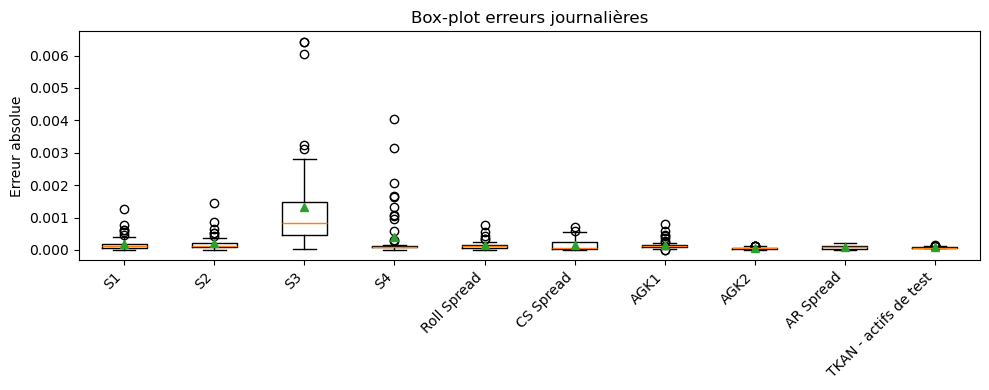

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049776,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
TKAN - actifs de test,NaN,0.000083,0.000065


In [7]:

WINDOW = 5          # nombre de jours d’historique vus par la séquence

X_tr_tkan, y_tr_tkan = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='seq',nb_assets=nb_asset_train,minutes_per_day=1440,window=WINDOW)
print("TRAIN TKAN :", X_tr_tkan.shape, y_tr_tkan.shape)

X_val_tkan, y_val_tkan = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='seq',nb_assets=nb_asset_train,minutes_per_day=1440,window=WINDOW)  
print("VAL   TKAN :", X_val_tkan.shape, y_val_tkan.shape)


input_shape = X_tr_tkan.shape[1:]   
tkan_model  = create_rnn_model(input_shape = input_shape,nb_assets = 1,rnn_layer = TKAN(units=100, num_heads=4, return_sequences=False),use_conv = False)   


history_tkan = tkan_model.fit(X_tr_tkan, y_tr_tkan,validation_data = (X_val_tkan, y_val_tkan),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)
    

X_te_tkan, y_te_tkan = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='seq',nb_assets=nb_asset_test,minutes_per_day=1440,window=WINDOW)
print("TEST TKAN :", X_te_tkan.shape, y_te_tkan.shape)

y_true_aligned  = y_true[WINDOW:]            
paper_daily_aligned  = paper_daily.iloc[WINDOW:]

df_compare_tkan = evaluate_and_plot(model = tkan_model,X = X_te_tkan,y = y_te_tkan,manager = manager_test,scaler_y = scaler_y,title = "TKAN - actifs de test",
                                    history = history_tkan,paper_metrics = df_perf,paper_daily = paper_daily_aligned,y_true_daily   = y_true_aligned)      
    
